# Desarrollo de distintos modelos con machine para predecir la probabilidad de que un cliente pague un préstamo

## Contexto de negocio:
* El equipo de ciencia de datos ha construido un modelo de regresión simpple para predecir la probabilidad en el incumplimiento de préstamos pero resulta ser que el modelo está funcionando mucho peor en producción que en las pruebas.

## Objetivo del trabajo:
* Construir un modelo de probabilidad que sea lo suficientemente certero para ponerlo en producción

## Fases de trabajo:
1. Análisis exploratorio de los datos para determinar las transformaciones de variables apropiadas.
2. Modelamiento con machine learning.
   1. Ajustar algunos modelos simples.
   2. Utilizar validación cruzada para seleccionar el mejor modelo simple.
   3. Combinar diversas técnicas de pre-modelación trabajando con clasificación binaria.
   4. Optimizar el modelo usando regresión logística y varias métricas como ROC/AUC.
   5. Contruir modelos más complejos utilizando validación cruzada.

## Dataset a utilizar:
1. El archivo 'loan_light.csv' contiene los detalles de 5000 préstamos
2. El archivo 'loan_param.xlsx' contiene la descripción de cada covariable

In [136]:
# Importación de libreria
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

### 1. Análisis exploratorio de los datos (EDA)

#### 1.1. Creación de los DataFrame

In [137]:
datos = pd.read_csv('datasets/loan_light.csv')
datos = datos.sample(frac=1)           # Desordenar las filas para evitar sesgos
datos.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
27,75000.0,Individual,3464.0,0.0,0.0,29.84,10,E,4.0,586.62,...,6.0,0.0,RENT,60,0.0,0.0,debt_consolidation,2017,0,manager
767,130000.0,Individual,2091.0,0.0,0.0,16.02,2,A,0.0,465.57,...,4.0,0.0,MORTGAGE,36,0.0,0.0,credit_card,2017,0,analyst
3663,60000.0,Individual,3716.0,0.0,0.0,19.26,6,C,0.0,252.86,...,3.0,0.0,RENT,60,0.0,0.0,debt_consolidation,2017,1,manager
2567,56000.0,Individual,23105.0,0.0,0.0,31.00,10,F,4.0,626.06,...,1.0,0.0,MORTGAGE,36,1.0,0.0,medical,2016,1,teacher
3664,43000.0,Individual,1045.0,0.0,0.0,7.70,4,C,1.0,333.53,...,4.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2016,0,technician


In [138]:
datos.keys()

Index(['annual_inc', 'application_type', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'grade',
       'inq_last_12m', 'installment', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'home_ownership', 'term', 'mort_acc',
       'num_tl_90g_dpd_24m', 'purpose', 'year', 'loan_default', 'job'],
      dtype='object')

In [139]:
df_descripcion = pd.read_excel('datasets/loan_param.xlsx').dropna()
df_descripcion.head()

,BrowseNotesFile,Description
0,loanAmnt,The listed amount of the loan applied for by t...
1,annualInc,The self-reported annual income provided by th...
2,application_type,Indicates whether the loan is an individual ap...
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months


In [140]:
df_descripcion.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


#### 1.2. Visualización con diagrama de barras para mostrar los préstamos pagos y los impagos

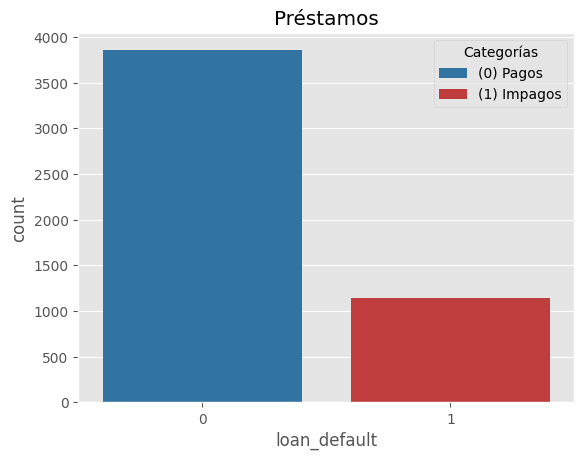

In [141]:
# Creación de una paleta personalizada
paleta = ['#1f77b4', '#d62728']

# Creación del gráfico con la paleta personalizada
sns.countplot(x='loan_default', data=datos, palette=paleta)
plt.title('Préstamos')

# Creación de leyenda personalizada
plt.legend(labels=['(0) Pagos', '(1) Impagos'], loc='upper right', title='Categorías')

plt.show()

In [142]:
datos.columns

Index(['annual_inc', 'application_type', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'grade',
       'inq_last_12m', 'installment', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'home_ownership', 'term', 'mort_acc',
       'num_tl_90g_dpd_24m', 'purpose', 'year', 'loan_default', 'job'],
      dtype='object')

In [143]:
cantidad_default = datos['loan_default'].sum()

probabilidad_default = (cantidad_default / len(datos)) * 100

print("Probabilidad de incumplimiento (%):", round(probabilidad_default))

Probabilidad de incumplimiento (%): 23


#### 1.3. Visualización de un histograma con los ingresos anuales

Text(0.5, 0, 'Ingreso anual')

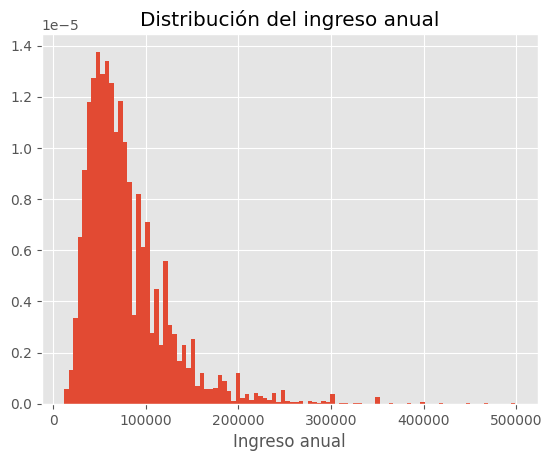

In [144]:
datos.annual_inc.hist(bins=100, density=True)
plt.title('Distribución del ingreso anual')
plt.xlabel('Ingreso anual')

Como los datos están sesgados, se resuelve hacer una transformación logarítmica

Text(0.5, 0, 'ingreso anual')

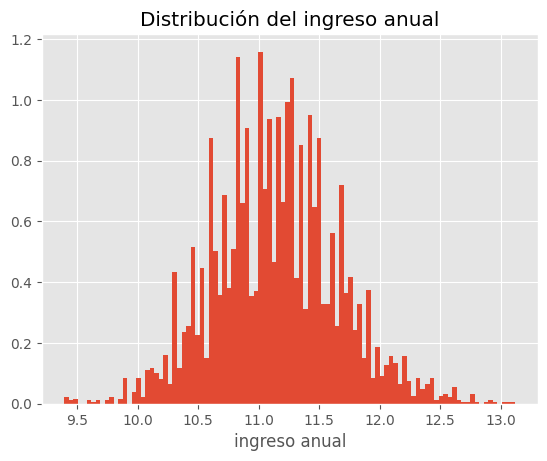

In [145]:
np.log(datos.annual_inc).hist(bins=100, density=True)
plt.title('Distribución del ingreso anual')
plt.xlabel('ingreso anual')

#### 1.4. Observaciones

1.4.1. ¿Es la distribución del ingreso anual diferente entre los aplicantes que no pagaron y los que sí pagaron?

Text(0.5, 1.0, 'Salario anual -- Estatus del préstamo')

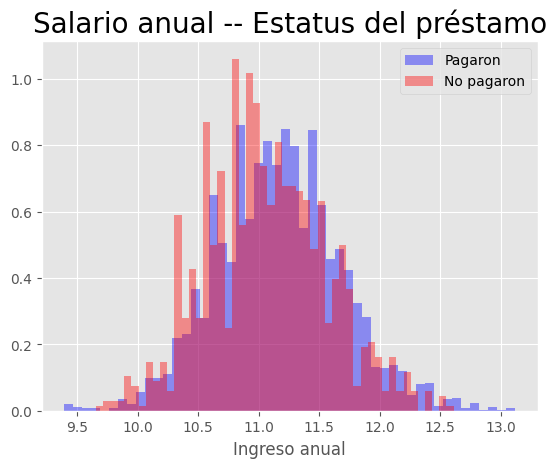

In [146]:
np.log(datos['annual_inc'][datos.loan_default == 0]).hist(bins=50, density=True, alpha=0.4, color='blue', label='Pagaron')
np.log(datos['annual_inc'][datos.loan_default == 1]).hist(bins=50, density=True, alpha=0.4, color='red', label='No pagaron')

plt.xlabel('Ingreso anual')
plt.legend()
plt.title('Salario anual -- Estatus del préstamo', fontsize=20)

1.4.2. Se puede observar que, si bien, arriba de 11.0 se empieza a notar que el ingreso ayuda a incrementar las posibilidades de que paguen el préstamo, no existe una diferencia significativa

#### 1.5. Asociación entre el ingreso anual y las cuotas mensuales

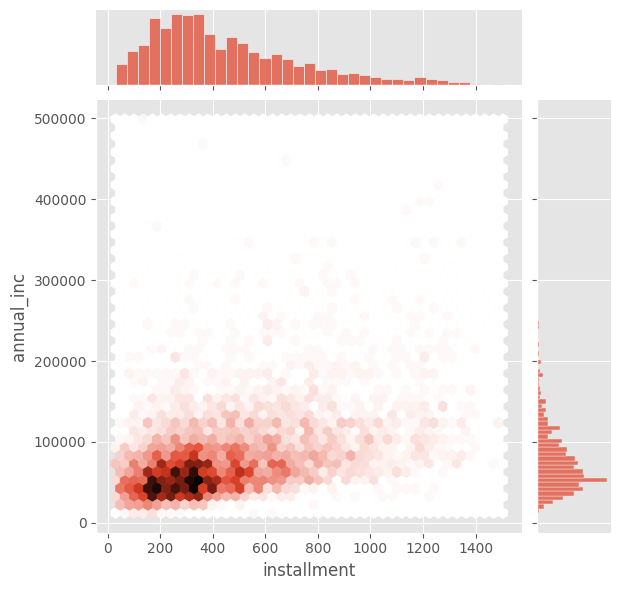

In [147]:
sns.jointplot(x='installment', y='annual_inc', data=datos, kind='hex')

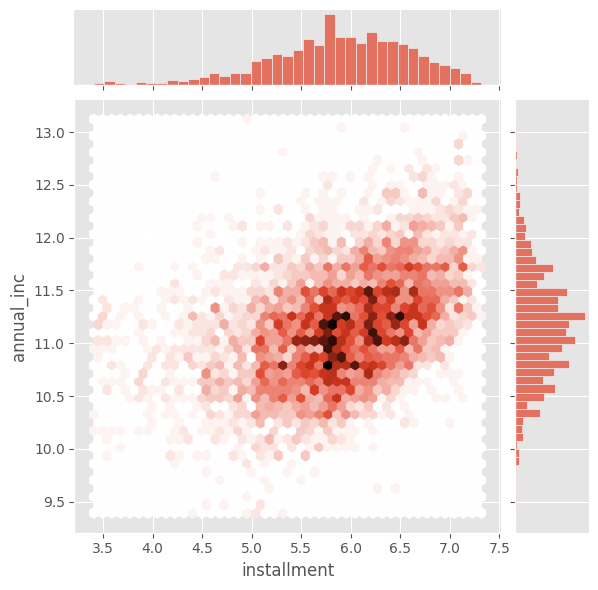

In [148]:
# Debido a que están sesgados, se usará la función logarítmica

sns.jointplot(x=np.log(datos['installment']), y=np.log(datos['annual_inc']), kind='hex')
plt.show()

#### 1.6. Observaciones
* Existe una relación lineal entre los logaritmos de los ingresos anuales y las cuotas mensuales. Esto quiere decir que a medida que aumentan los ingresos anuales, tambien aumenta el monto que aceptan de sus cuotas mensuales.

#### 1.7. Asociación entre el ingreso anual y las cuotas mensuales

* A continuación, se muestran otras figuras que muestran la relación entre covariables numéricas y la probabilidad de impago, así como con el ingreso anual.

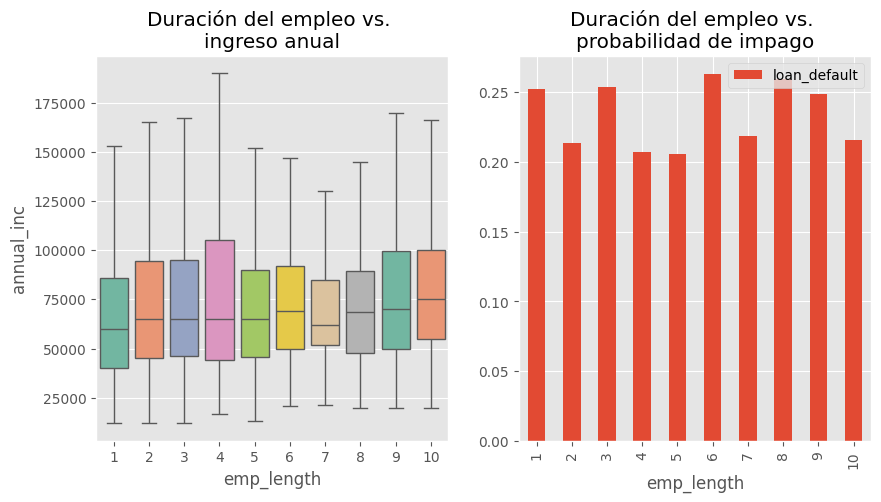

In [149]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x='emp_length', y = 'annual_inc', data = datos, showfliers=False, ax=ax1, palette='Set2') # showfliers=False para que se vea bonito
ax1.set_title("Duración del empleo vs. \ningreso anual")
datos[["emp_length",'loan_default']].groupby("emp_length").mean().plot.bar(rot=90,ax=ax2)
ax2.set_title("Duración del empleo vs. \nprobabilidad de impago")
plt.show()

* Observaciones: no se observa una relación certera entre la probabilidad de impago y la duración del empleo

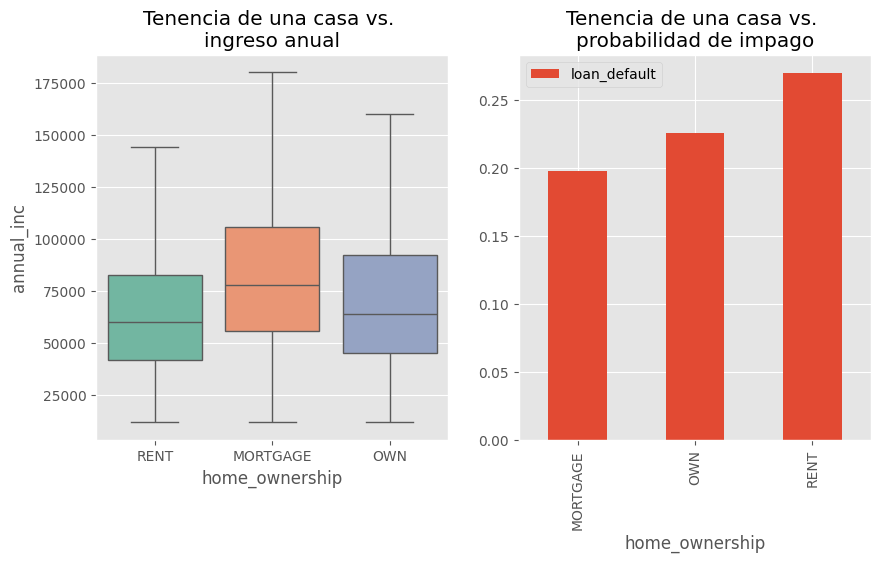

In [150]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x="home_ownership", y="annual_inc", data=datos, showfliers=False, ax =ax1, palette='Set2') #showfliers=False para que se vea bonito
ax1.set_title("Tenencia de una casa vs. \ningreso anual")
datos[["home_ownership",'loan_default']].groupby("home_ownership").mean().plot.bar(rot=90, ax=ax2)
ax2.set_title("Tenencia de una casa vs. \nprobabilidad de impago")
plt.show()

* Observaciones: se observa que una hipoteca presenta una probabilidad de impago (20 %) por debajo de la media (23 %). Puede ser que las personas sean más responsables cuando compran una casa o departamento via préstamo hipotecario.

Y estas son algunas gráficas que muestran la relación entre diversas variables categóricas y la probabilidad de impago

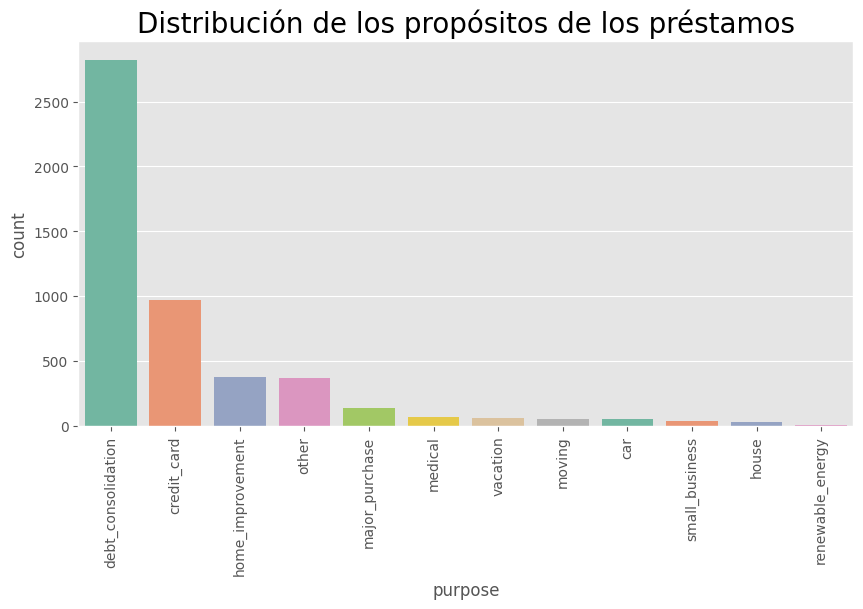

In [151]:
plt.figure(figsize=(10, 5))
datos.emp_length.value_counts()
sns.countplot(x='purpose', order=datos['purpose'].value_counts().index, data=datos, palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribución de los propósitos de los préstamos", fontsize=20)
plt.show()

* Observaciones: la mayor concentración de los préstamos se encuentra en el valor debt_consolidation. Esto  es, radica en simplicar la gestión de deudas y reducir la tasa de interés total, cambiando múltiples deudas por un único préstamo. Luego se podria decir que credit_card, home_improvement y other. El resto no contribuye significativamente.

Text(0.5, 1.0, 'Probabilidad de impago según propósito del préstamo')

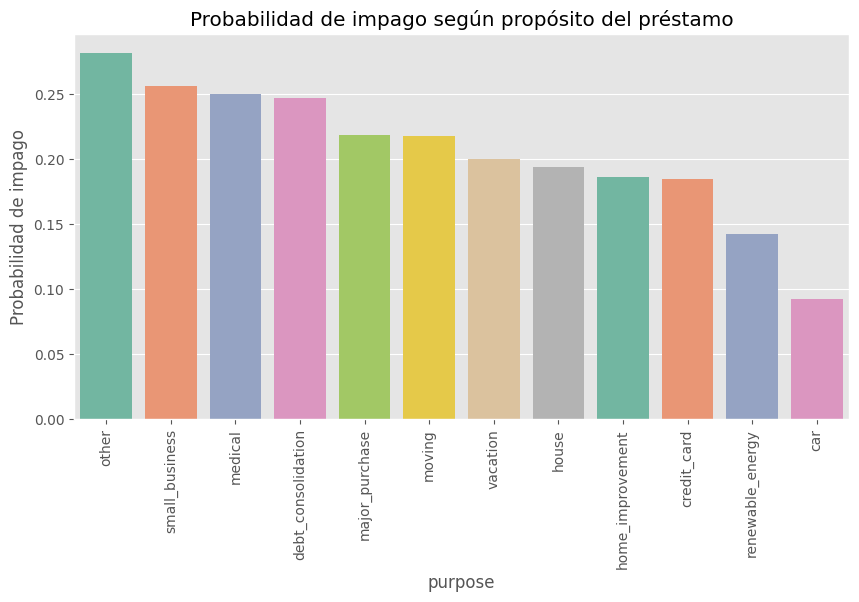

In [152]:
plt.figure(figsize= (10,5))
proposito_impago = datos[["loan_default", "purpose"]].groupby("purpose").mean()
proposito_impago = proposito_impago.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=proposito_impago.index[:30],
y=proposito_impago["loan_default"][:30].values,
orient="v",
palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("Probabilidad de impago")
plt.title("Probabilidad de impago según propósito del préstamo")

* Observaciones: ahora "other" es el principal, y junto a "debt_consolidation" eran los más importantes según cantidad. Esto quiere decir que aquí debería estar el foco de atención. Sería interesante si "other" fuese desgranado.

Se analizaron los datos unicos de job y se encuentran algunas profesiones que son iguales pero escritas de forma distinta, por lo cual, se homogeneizarán los nombres

In [153]:
job_unique = datos['job'].unique()
count_job_unique = len(job_unique)
print("Existen", count_job_unique, " profesiones")
job_unique

Existen 119  profesiones


array(['manager', 'analyst', 'teacher', 'technician', 'administrator',
       'other', 'clerk', 'coordinator', 'supervisor', 'specialist',
       'principal', 'assistant', 'driver', 'foreman', 'sergeant',
       'operator', 'engineer', 'welder', 'accountant', 'admin', 'planner',
       'president', 'representative', 'owner', 'therapist', 'captain',
       'laborer', 'professor', 'consultant', 'officer', 'custodian',
       'development', 'director', 'finance', 'counselor', 'it',
       'installer', 'advisor', 'operations', 'broker', 'associate',
       'adjuster', 'server', 'lead', 'tech', 'inspector', 'agent', 'cook',
       'nurse', 'developer', 'machinist', 'chef', 'mechanic',
       'dispatcher', 'production', 'support', 'buyer', 'scientist',
       'superintendent', 'worker', 'attorney', 'carrier', 'partner',
       'sales', 'ceo', 'controller', 'underwriter', 'administration',
       'dealer', 'management', 'auditor', 'leader', 'banker', 'realtor',
       'teller', 'designer', 'b

In [154]:
# Crear un diccionario de reemplazo
reemplazos = {
    'tech': 'technologist',
    'technologist': 'technologist',
    'admin': 'administrator',
    'administration': 'administrator',
    'administrator': 'administrator',
    'manger': 'manager',
    'management': 'manager',
    'manager': 'manager',
    'teacher': 'educator'
}

# Reemplazar los valores en la columna 'job'
datos['job'] = datos['job'].replace(reemplazos)

job_unique = datos['job'].unique()
count_job_unique = len(job_unique)
print("Existen", count_job_unique, " profesiones")
job_unique

Existen 113  profesiones


array(['manager', 'analyst', 'educator', 'technician', 'administrator',
       'other', 'clerk', 'coordinator', 'supervisor', 'specialist',
       'principal', 'assistant', 'driver', 'foreman', 'sergeant',
       'operator', 'engineer', 'welder', 'accountant', 'planner',
       'president', 'representative', 'owner', 'therapist', 'captain',
       'laborer', 'professor', 'consultant', 'officer', 'custodian',
       'development', 'director', 'finance', 'counselor', 'it',
       'installer', 'advisor', 'operations', 'broker', 'associate',
       'adjuster', 'server', 'lead', 'technologist', 'inspector', 'agent',
       'cook', 'nurse', 'developer', 'machinist', 'chef', 'mechanic',
       'dispatcher', 'production', 'support', 'buyer', 'scientist',
       'superintendent', 'worker', 'attorney', 'carrier', 'partner',
       'sales', 'ceo', 'controller', 'underwriter', 'dealer', 'auditor',
       'leader', 'banker', 'realtor', 'teller', 'designer', 'bookkeeper',
       'paralegal', 'vp', '

Text(0.5, 1.0, 'Distribución de los trabajos')

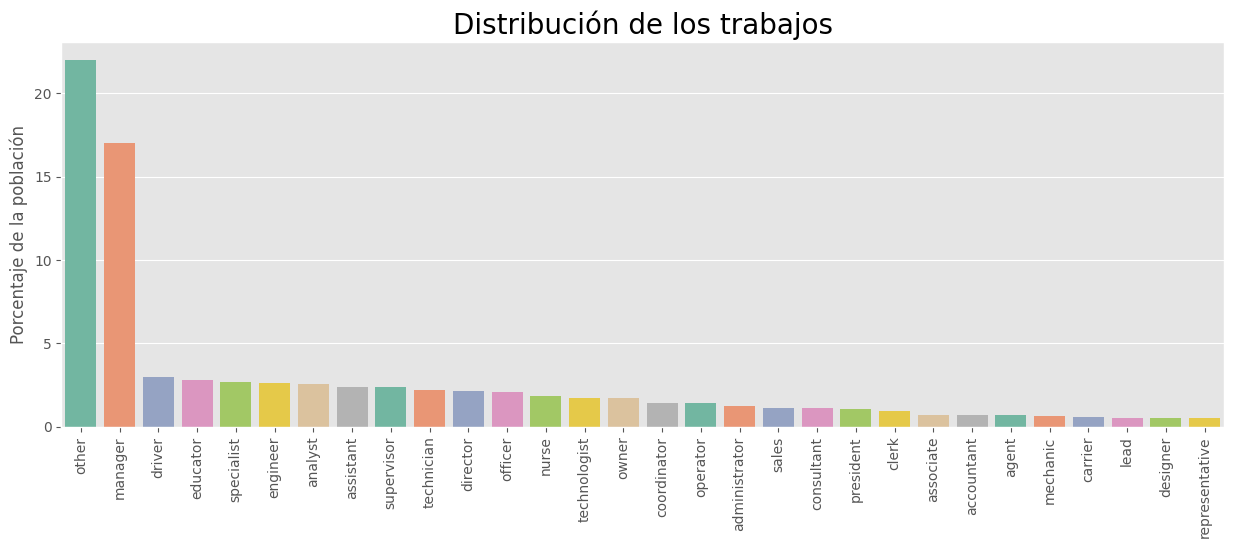

In [155]:
plt.figure(figsize= (15,5))
sns.barplot(x=datos["job"].value_counts()[:30].index.values ,
y=100 * datos.job.value_counts()[:30].values / len(datos),
orient="v",
palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("Porcentaje de la población")
plt.title("Distribución de los trabajos", fontsize=20)

* "other" y "manager" son los principales.

Text(0.5, 1.0, 'Probabilidad de impago según tipo de trabajo')

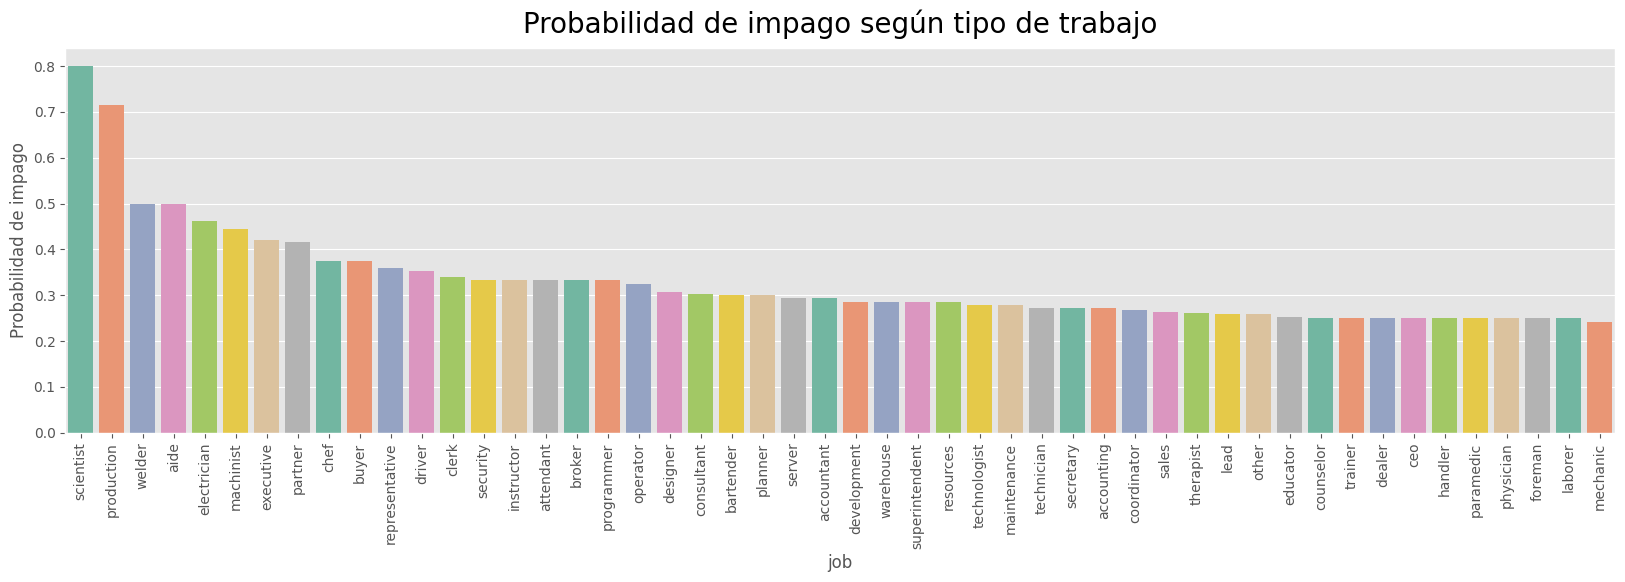

In [156]:
plt.figure(figsize= (20,5))
df_trabajo_impago = datos[["loan_default", "job"]].groupby("job").mean()
df_trabajo_impago = df_trabajo_impago.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_trabajo_impago.index[:50],
y=df_trabajo_impago["loan_default"][:50].values,
orient="v",
palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("Probabilidad de impago")
plt.title("Probabilidad de impago según tipo de trabajo", fontsize=20,
verticalalignment='bottom')

* Observaciones: es extraño que muchos puestos laborales tengan una probabilidad tan elevado de impago en los préstamos. Científicos es un 80 %, production es un 70 %. Con estos datos se podría extraer lo siguiente:
  * 1. Se podría optar por no dar préstamos a los que tienen igual o superior al 50 % (scientist, production, welder, aide). No importa el tipo de interés si no te devolverán el dinero.
  * 2. Calibrar distintas tasas de interés según la probabilidad de impago, es decir, a los que tienen mayores probabilidad de impago, se les otorga préstamos con tasa de interés más elevada.

#### 1.8. Añadiendo una nueva variable
El pago anual que debe el prestatario, como fracción de sus ingresos anuales, es una medida estándar que
se utiliza para evaluar si se debe conceder un préstamo. Definamos una nueva variable “install_income”
que codifique la cuota como una fracción de los ingresos anuales y estudiemos su asociación con las demás
características (“cuota” se dice installment en inglés):

Text(0.5, 0, 'Cuota / Ingresos')

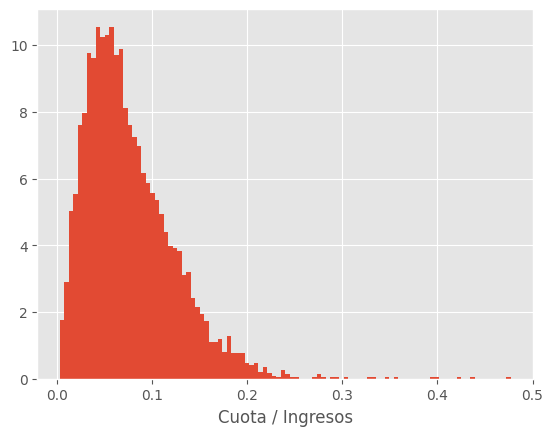

In [157]:
datos['install_income'] = 12 * datos.installment / datos.annual_inc
H = plt.hist(datos['install_income'], bins=100, density=True)
plt.xlabel(r"Cuota / Ingresos")

Para investigar más fácilmente la asociación de esta variable con la probabilidad de impago, se define una nueva covariable llamada install_income_disc que será una versión discretizada de install_income

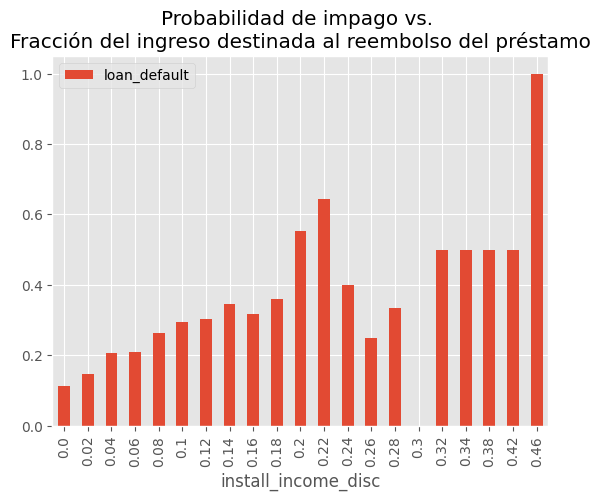

In [158]:
# Discreticemos la variable "install_income" para estudiar la probabilidad de impago como una función de "install_income"
datos["install_income_disc"] = (datos.install_income * 50).astype(int) / 50
# discretización
mean_values = datos[["loan_default", "install_income_disc"]].groupby("install_income_disc").mean()
mean_values.plot(kind='bar', rot=90)
plt.title("Probabilidad de impago vs. \nFracción del ingreso destinada al reembolso del préstamo")
plt.show()
datos = datos.drop(["install_income_disc"], axis=1)

Observaciones:
* Se observa una asociación claramente positiva: a medida que la fracción del ingreso, destinada al reembolso del préstamo se incrementa, la probabilidad de impago se incrementa fuertemente. Aunque es de notar que entre install_income_disc igual 0.22 y 0.42 los datos se compartan de forma extraña. 
* De aquí se puede extraer que install_income superiores a 0.4 es mejor no dar préstamos, porque la probabilidad de impago se acerca al 100.
* Sería prudente conocer el nivel de gasto también y el nivel de ahorro, no es suficiente con solo el ingreso.

#### 1.9. Matriz de correlación
Se visualiza la matriz de correlación para todas las columnas numéricas usando el comando sns.heatmap()

In [205]:
# Filtra solo las columnas numéricas
datos_numericos = datos.select_dtypes(include=[np.number])

# Calcula la matriz de correlación
df_correlacion = datos_numericos.corr()

print("Matriz de correlación:")
df_correlacion

Matriz de correlación:


,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,year,loan_default,install_income
annual_inc,1.000000,0.378378,-0.006988,0.058947,-0.203361,0.099916,0.118773,0.408403,0.437400,0.188844,-0.062597,0.098275,0.332078,0.000643,0.040133,-0.081170,-0.317027
avg_cur_bal,0.378378,1.000000,0.002599,0.044949,-0.076966,0.096078,0.064611,0.159386,0.194908,-0.103173,-0.084218,0.110693,0.495152,0.005368,0.050524,-0.086758,-0.139786
chargeoff_within_12_mths,-0.006988,0.002599,1.000000,0.135676,0.007021,0.032354,0.024785,-0.021993,-0.025250,-0.012165,-0.020352,-0.007214,0.021617,0.256971,-0.025421,-0.005364,-0.013069
delinq_2yrs,0.058947,0.044949,0.135676,1.000000,-0.006261,0.018794,0.057904,0.002321,-0.008212,-0.019594,-0.042804,-0.017682,0.098569,0.560949,-0.027559,0.007046,-0.044180
dti,-0.203361,-0.076966,0.007021,-0.006261,1.000000,0.014258,0.038759,0.054917,0.040851,0.168643,-0.040668,0.067748,-0.010512,-0.025818,-0.014868,0.108522,0.237742
emp_length,0.099916,0.096078,0.032354,0.018794,0.014258,1.000000,-0.018711,0.076526,0.092454,0.080004,0.019035,0.056639,0.202490,0.010622,-0.036596,-0.018750,-0.045956
inq_last_12m,0.118773,0.064611,0.024785,0.057904,0.038759,-0.018711,1.000000,0.058537,0.036534,0.057715,0.075194,0.039429,0.114594,0.050889,0.023432,0.072444,-0.062720
installment,0.408403,0.159386,-0.021993,0.002321,0.054917,0.076526,0.058537,1.000000,0.953689,0.198432,-0.070192,0.164677,0.179366,-0.032046,0.006469,0.092620,0.601983
loan_amnt,0.437400,0.194908,-0.025250,-0.008212,0.040851,0.092454,0.036534,0.953689,1.000000,0.194852,-0.081577,0.388966,0.216845,-0.036545,0.010529,0.088231,0.535397
num_actv_bc_tl,0.188844,-0.103173,-0.012165,-0.019594,0.168643,0.080004,0.057715,0.198432,0.194852,1.000000,-0.050070,0.051253,0.056032,-0.012166,-0.011584,0.038843,0.047888


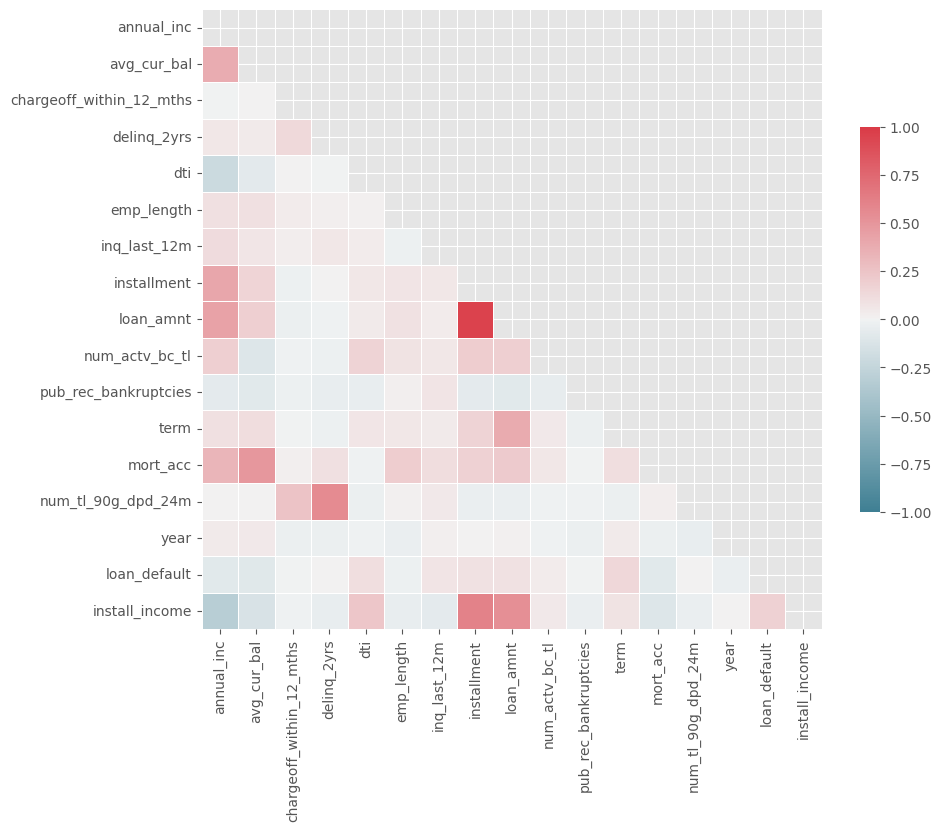

In [206]:
# Enmascarar la parte superior para efectos de la visualización
mascara = np.zeros_like(df_correlacion, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Dibuja el mapa de calor con la máscara y las dimensiones correctas
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlacion, mask=mascara, vmax=1, vmin=-1, cmap=cmap,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [207]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Supongamos que 'datos' es tu DataFrame con las variables numéricas
datos_numericos = datos.select_dtypes(include=[np.number])

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["feature"] = datos_numericos.columns
vif_data["VIF"] = [variance_inflation_factor(datos_numericos.values, i) for i in range(datos_numericos.shape[1])]

# Mostrar resultados
print(vif_data)

                     feature         VIF
0                 annual_inc   12.496779
1                avg_cur_bal    2.545068
2   chargeoff_within_12_mths    1.082475
3                delinq_2yrs    1.709120
4                        dti    6.055100
5                 emp_length    4.131497
6               inq_last_12m    2.101231
7                installment  111.889624
8                  loan_amnt  112.948975
9             num_actv_bc_tl    3.906925
10      pub_rec_bankruptcies    1.181950
11                      term   51.589721
12                  mort_acc    2.515618
13        num_tl_90g_dpd_24m    1.613109
14                      year   54.803853
15              loan_default    1.405652
16            install_income   14.920008


Observaciones: 
* Podemos ver aquí que installment y loan_amnt están altamente correlacionados. En general, podemos utilizar inicialmente una matriz de correlación como una técnica de selección de variables para eliminar las que estén extremadamente correlacionadas para evitar la multicolinealidad. Se supondrá lo siguiente para comenzar:
* Si existe correlación superior al 0.9 una de las dos variables será eliminada.
* Se extrae el VIF para confirmar el punto 1. Aquí se entiende que installment debe ser eliminado.
* Las variables: "annual_inc", "year", "term", serán evaluadas más adelante haciendo un feature_importance.

In [ ]:
datos = datos.drop(columns=['installment'])

### 2. Modelamiento con machine learning
Se construirá un modelo estándar de regresión logística. En general, es importante y extremadamente útil crear primero modelos básicos/simples que puedan ser comparados con modelos más complejos más adelante.

#### 2.1. Regresión logística
Usando la función LogisticRegression() de scikit-learn, se escribe una función que se llame aplicar_regresion_logistica(X,y) que aplica una regresión logística a la matriz de covariables X y
a su variable de respuesta asociada y.

In [160]:
# Importación de librería para crear el modelado
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

In [161]:
def aplicar_regresion_logistica(X,y):
    """
    Aplica una regresión logística a la matriz de características X y al resultado, binario y
    """
    clasif = LogisticRegression(solver='lbfgs', tol=10**-4,
    fit_intercept=True,
    multi_class='multinomial').fit(X,y)
    return clasif

Ahora se crea un modelo básico de regresión logistica para predecir el impago de los préstamos usando solo una característica: install_income. 


In [162]:
# Usaremos una partición 70%/30% de entrenamiento/validacion
n_total = len(datos)
n_entrenamiento = int(0.7*n_total)
X, y = datos[["install_income"]], datos.loan_default
X_entrenamiento, y_entrenamiento = X[:n_entrenamiento], y[:n_entrenamiento]
X_pruebas, y_pruebas = X[n_entrenamiento:], y[n_entrenamiento:]

In [163]:
modelo1 = aplicar_regresion_logistica(X_entrenamiento, y_entrenamiento) 

y_pruebas_pred = modelo1.predict_proba(X_pruebas)[:,1] 

#### 2.2. Evaluación
Se grafica la curva ROC del modelo1 y se halla el área bajo la curva (AUC)

Text(0.5, 1.0, 'Curva ROC -- Modelo de línea base')

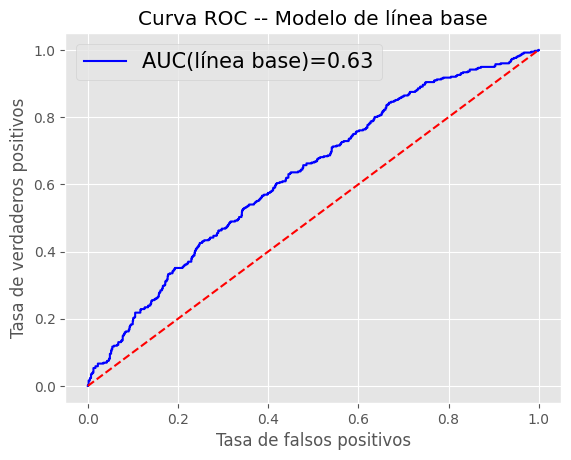

In [164]:
#FPR= False Positive Rate (Tasa de falsos positivos)
#TPR True Positive Rate (Tasa de verdaderos positivos)
fpr, tpr, _ = roc_curve(y_pruebas, y_pruebas_pred) # Calculando FPR y TPR
auc_linea_base = auc(fpr, tpr) # calculando la AUC (área bajo la curva ROC)
plt.plot(fpr, tpr, "b-", label="AUC(línea base)={:2.2f}".format(auc_linea_base))
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("Curva ROC -- Modelo de línea base")

#### 2.3. Observaciones

1. Considerando el modelo, este no debería ser el modelo final. Esto se debe a que no hemos explorado la contribución de otras variables, que además de contener información valiosa podrían ser variables de confusión con el efecto percibido de install_income en la variable respuesta. Esta subexplotación de la información se denomina subajuste, underfitting en inglés.
2. Colocar todas las variables disponibles en el modelo, para aprovechar al máximo nuestra información disponible sería una mala idea. Si ciegamente utilizamos todas las variables en nuestro modelo de ajuste, ocurre un fenómeno llamado sobreajuste. Esto es cuando un modelo estadístico “encaja” demasiado bien en un conjunto particular de datos, que bien puede ser ruidoso y exhibir aleatoriedad y por lo tanto no puede predecir futuras observaciones diferentes de manera confiable. Además de que podría correrse el riesgo de la multicolinealidad.

#### 2.4. Comentario adicional

1. En la mayoría de los casos, se trabajará con conjuntos de datos con muchas características que tienen cada una su propia distribución. Por lo general, se dedica una gran cantidad de tiempo a la selección de características y muchos modelos se entrenan durante este tiempo. Es extremadamente raro que simplemente se conecten todas las características y se calibren una sola vez para obtener el modelo óptimo. 
2. Hay muchas técnicas diferentes asociadas con la selección de características y una mirada exhaustiva a todas ellas está fuera del alcance de este caso. Para simplificar, demostraremos el entrenamiento y las pruebas de los modelos en modelos de una sola característica y luego pasaremos directamente a los modelos de múltiples características para mostrar los numerosos escenarios posibles que puede encontrar. Se podría considerar un posterior análisis con validación cruzada en numerosos subconjuntos de características basándonos buscando qué conjunto de características optimiza realmente el modelo que estamos tratando de crear.

#### 2.5. Validación cruzada
2.5.1. A continuación se muestra un ejemplo de validación cruzada de 5 folds

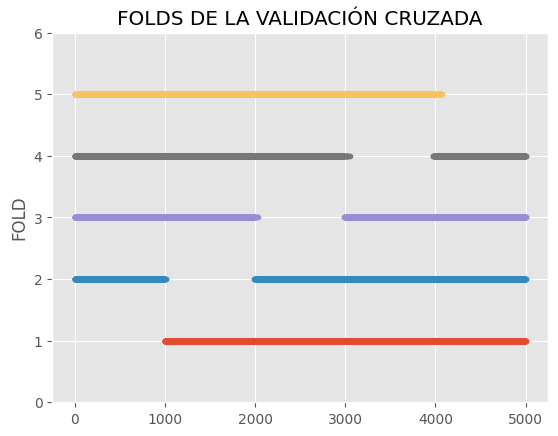

In [165]:
skf = StratifiedKFold(n_splits=5)
for k, (indice_entrenamiento, indice_pruebas) in enumerate( skf.split(X, y) ):
    plt.plot(indice_entrenamiento, [k+1 for _ in indice_entrenamiento], ".")
    plt.ylim(0,6)
    plt.ylabel("FOLD")
    plt.title("FOLDS DE LA VALIDACIÓN CRUZADA")

El siguiente código define la función calcular_AUC(X, y, indice_entrenamiento, indice_pruebas), la cual calcula el AUC de un modelo entrenado con indice_entrenamiento e indice_pruebas.

Ahora vamos a estimar y comparar, a través de validación cruzada, el desempeño de todos los modelos simples que solamente usan una sola característica numérica como input. Como se dijo en la sección de EDA, usaremos la transformación logarítmica para las variables anual_income, loan_amount y avg_cur_bal.

In [166]:
# Creamos una lista solo con las características numéricas (o sea, las no categóricas)
numericas = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
datos_numericas = datos.select_dtypes(include=numericas)
datos_numericas = datos_numericas.drop(["installment", "year"], axis=1)
# Usando una escala logarítmica en los casos apropiados
datos_numericas["annual_inc"] = np.log10(datos_numericas["annual_inc"])
datos_numericas["loan_amnt"] = np.log10(datos_numericas["loan_amnt"])
datos_numericas["avg_cur_bal"] = np.log10(1.+datos_numericas["avg_cur_bal"])

In [167]:
datos_numericas.keys()

Index(['annual_inc', 'avg_cur_bal', 'chargeoff_within_12_mths', 'delinq_2yrs',
       'dti', 'emp_length', 'inq_last_12m', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'term', 'mort_acc', 'num_tl_90g_dpd_24m',
       'loan_default', 'install_income'],
      dtype='object')

Calculemos las AUC estimadas con validación cruzada para cada uno de los modelos de una sola variable:

In [168]:
# Función calcular_AUC
def calcular_AUC(X, y, indice_entrenamiento, indice_pruebas):
    """
    caracteristicas, variable dependiente: X, y
    particion del conjunto de datos: indice_entrenamiento, indice_pruebas
    """
    X_entrenamiento, y_entrenamiento = X.iloc[indice_entrenamiento], y.iloc[indice_entrenamiento]
    X_pruebas, y_pruebas = X.iloc[indice_pruebas], y.iloc[indice_pruebas]
    clf = LogisticRegression(solver='lbfgs', tol=1e-4, fit_intercept=True, multi_class='multinomial').fit(X_entrenamiento, y_entrenamiento)
    probab_impago_pruebas = clf.predict_proba(X_pruebas)[:, 1]
    fpr, tpr, _ = roc_curve(y_pruebas, probab_impago_pruebas)
    auc_puntaje = auc(fpr, tpr)
    return auc_puntaje, fpr, tpr

A continuación se crea una función llamada cross_validation_AUC(X,y,nfold) con validación cruzada de 10 folds y genera una lista que contenie el área bajo la curva para cada fold de la validación cruzada.

In [169]:
# Función para calcular AUC con validación cruzada
def cross_validation_AUC(X, y, nfold=10):
    """
    Usa una validación cruzada de n folds para calcular las AUC estimadas
    """
    skf = StratifiedKFold(n_splits=nfold)  # Crear una partición para hacer validación cruzada
    auc_lista = []  # Esta lista contiene las AUC estimadas asociadas a cada fold
    for indice_entrenamiento, indice_pruebas in skf.split(X, y):
        auc_puntaje, _, _ = calcular_AUC(X, y, indice_entrenamiento, indice_pruebas)
        auc_lista.append(auc_puntaje)
    return auc_lista

In [170]:
modelos_desempeno = pd.DataFrame({}) # Este DataFrame contendrá los estimados de las AUC
for llave in datos_numericas.keys():
    if llave == "loan_default": 
        continue
    X_completo, y_completo = datos_numericas[[llave]], datos_numericas.loan_default
    auc_lista = cross_validation_AUC(X_completo, y_completo, nfold=10)
    modelos_desempeno["SIMPLE:" + llave] = auc_lista

In [171]:
modelos_desempeno

,SIMPLE:annual_inc,SIMPLE:avg_cur_bal,SIMPLE:chargeoff_within_12_mths,SIMPLE:delinq_2yrs,SIMPLE:dti,SIMPLE:emp_length,SIMPLE:inq_last_12m,SIMPLE:loan_amnt,SIMPLE:num_actv_bc_tl,SIMPLE:pub_rec_bankruptcies,SIMPLE:term,SIMPLE:mort_acc,SIMPLE:num_tl_90g_dpd_24m,SIMPLE:install_income
0,0.505590,0.531974,0.505181,0.499273,0.570880,0.496818,0.554450,0.573652,0.543973,0.488410,0.573902,0.529770,0.495410,0.581243
1,0.568789,0.562847,0.501295,0.468185,0.553484,0.521055,0.550882,0.550291,0.487944,0.473025,0.546791,0.545507,0.494182,0.612172
2,0.594639,0.570687,0.503886,0.488081,0.613819,0.440994,0.484831,0.561994,0.540462,0.477547,0.588560,0.575561,0.493773,0.643430
3,0.562530,0.552129,0.493924,0.512016,0.534715,0.524020,0.546414,0.571067,0.525771,0.483614,0.574308,0.586369,0.504077,0.626008
4,0.549373,0.531090,0.496951,0.474387,0.574602,0.491937,0.542541,0.572716,0.561084,0.478069,0.586957,0.514918,0.502372,0.632671
5,0.570130,0.570514,0.500847,0.449407,0.585692,0.532377,0.561457,0.545093,0.521988,0.480294,0.584359,0.559447,0.511316,0.601299
6,0.523715,0.496578,0.506494,0.498927,0.602756,0.490446,0.531383,0.572456,0.496510,0.501796,0.543083,0.509452,0.490785,0.595031
7,0.575054,0.567036,0.503896,0.521039,0.550141,0.547826,0.575189,0.535551,0.472885,0.478871,0.565217,0.634670,0.495878,0.604291
8,0.565387,0.584517,0.503444,0.456431,0.611654,0.550875,0.539266,0.593123,0.570695,0.469283,0.585658,0.580576,0.494241,0.654229
9,0.572931,0.555223,0.484754,0.530299,0.544608,0.548108,0.584382,0.530028,0.542484,0.506990,0.565726,0.572343,0.466505,0.609960


A continuación se construye un boxplot (diagrama de cajas) que muestra la distribución de los puntajes de validación cruzada de cada variable

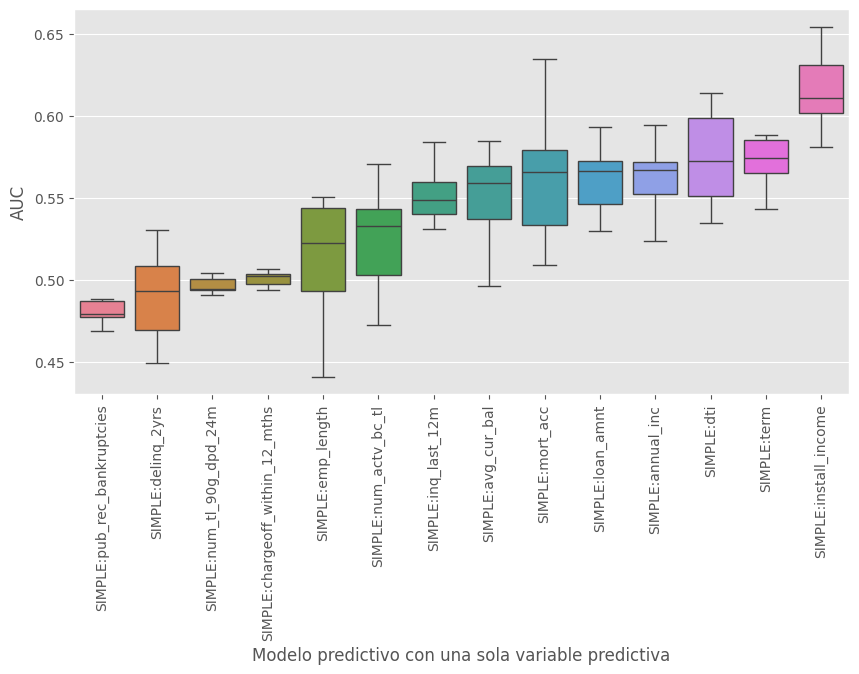

In [172]:
def dibujar_boxplot_ordenado(df_modelo):
    """
    Muestra una lista de boxplots, ordenados por los valores medianos
    """
    df = df_modelo[df_modelo.median().sort_values().index]
    df_melted = pd.melt(df)
    palette = sns.color_palette("husl", len(df.columns))
    sns.boxplot(x="variable", y="value", data=df_melted, palette=palette, showfliers=False)
    plt.xticks(rotation=90)

plt.figure(figsize=(10, 5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola variable predictiva")
plt.ylabel("AUC")
plt.show()

2.5.2. Consideremos el modelo que consiste en utilizar todas las características numéricas (y ninguna de las características categóricas). Lleve a cabo un análisis de validación cruzada de 10 folds para determinar si este modelo tiene un mejor rendimiento predictivo que el mejor modelo de una sola característica. Vuelva a utilizar el método del gráfico de cajas como hicimos en el ejercicio 6.

In [173]:
X_completo, y_completo = datos_numericas.drop(["loan_default"], axis=1), datos_numericas.loan_default
auc_lista = cross_validation_AUC(X_completo, y_completo)
modelos_desempeno["TODAS_LAS_NUMERICAS"] = auc_lista
modelos_desempeno

,SIMPLE:annual_inc,SIMPLE:avg_cur_bal,SIMPLE:chargeoff_within_12_mths,SIMPLE:delinq_2yrs,SIMPLE:dti,SIMPLE:emp_length,SIMPLE:inq_last_12m,SIMPLE:loan_amnt,SIMPLE:num_actv_bc_tl,SIMPLE:pub_rec_bankruptcies,SIMPLE:term,SIMPLE:mort_acc,SIMPLE:num_tl_90g_dpd_24m,SIMPLE:install_income,TODAS_LAS_NUMERICAS
0,0.505590,0.531974,0.505181,0.499273,0.570880,0.496818,0.554450,0.573652,0.543973,0.488410,0.573902,0.529770,0.495410,0.581243,0.643828
1,0.568789,0.562847,0.501295,0.468185,0.553484,0.521055,0.550882,0.550291,0.487944,0.473025,0.546791,0.545507,0.494182,0.612172,0.625761
2,0.594639,0.570687,0.503886,0.488081,0.613819,0.440994,0.484831,0.561994,0.540462,0.477547,0.588560,0.575561,0.493773,0.643430,0.689528
3,0.562530,0.552129,0.493924,0.512016,0.534715,0.524020,0.546414,0.571067,0.525771,0.483614,0.574308,0.586369,0.504077,0.626008,0.648696
4,0.549373,0.531090,0.496951,0.474387,0.574602,0.491937,0.542541,0.572716,0.561084,0.478069,0.586957,0.514918,0.502372,0.632671,0.658634
5,0.570130,0.570514,0.500847,0.449407,0.585692,0.532377,0.561457,0.545093,0.521988,0.480294,0.584359,0.559447,0.511316,0.601299,0.678509
6,0.523715,0.496578,0.506494,0.498927,0.602756,0.490446,0.531383,0.572456,0.496510,0.501796,0.543083,0.509452,0.490785,0.595031,0.606256
7,0.575054,0.567036,0.503896,0.521039,0.550141,0.547826,0.575189,0.535551,0.472885,0.478871,0.565217,0.634670,0.495878,0.604291,0.667126
8,0.565387,0.584517,0.503444,0.456431,0.611654,0.550875,0.539266,0.593123,0.570695,0.469283,0.585658,0.580576,0.494241,0.654229,0.707081
9,0.572931,0.555223,0.484754,0.530299,0.544608,0.548108,0.584382,0.530028,0.542484,0.506990,0.565726,0.572343,0.466505,0.609960,0.657730


Text(0, 0.5, 'AUC')

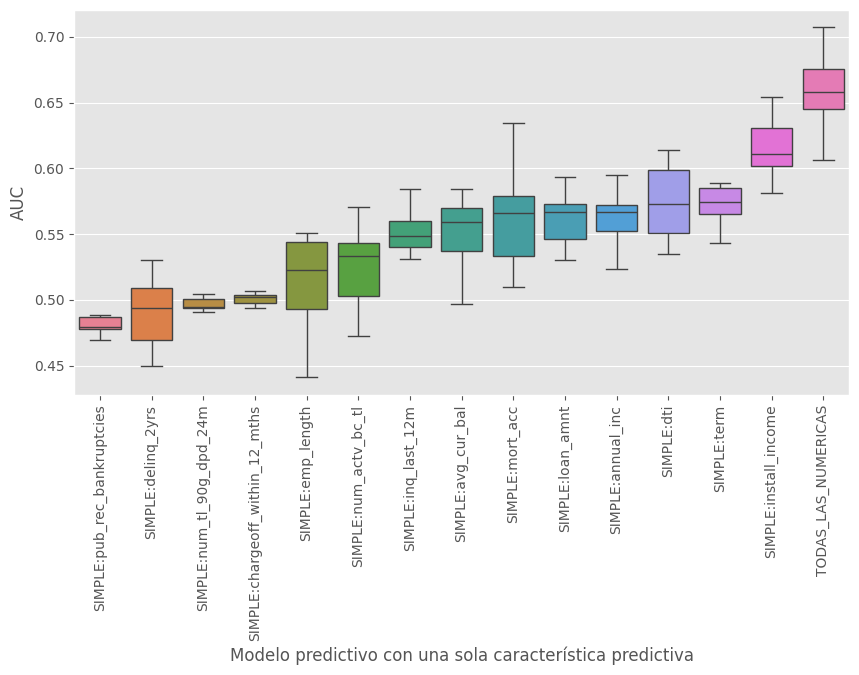

In [174]:
plt.figure(figsize= (10,5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola característica predictiva")
plt.ylabel("AUC")

Vemos que el modelo combinado funciona mejor que el mejor modelo de una sola característica. Por lo tanto, seguiremos adelante con él durante el resto de este caso. Posteriormente, se realizó un proceso iterativo considerando distintas variables pero no se logró una mejora significativa. Es decir, depende más de las muestras en los folds que de las variables que se consideren.

#### 2.6. Incorporando las variables categóricas
La calificación de un préstamo (es decir, la característica que le asigna una calificadora de créditos) no ha sido usada hasta ahora. Esta es la distribución de esta variable (grade):

In [175]:
datos_cualitativos = datos.select_dtypes(include=['object'])
datos_cualitativos.columns

Index(['application_type', 'grade', 'home_ownership', 'purpose', 'job'], dtype='object')

In [176]:
datos_cualitativos

,application_type,grade,home_ownership,purpose,job
27,Individual,E,RENT,debt_consolidation,manager
767,Individual,A,MORTGAGE,credit_card,analyst
3663,Individual,C,RENT,debt_consolidation,manager
2567,Individual,F,MORTGAGE,medical,educator
3664,Individual,C,RENT,debt_consolidation,technician
...,...,...,...,...,...
3999,Individual,C,MORTGAGE,debt_consolidation,administrator
1663,Individual,E,MORTGAGE,home_improvement,manager
3716,Individual,D,RENT,other,driver
3041,Individual,A,RENT,credit_card,marketing


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'E'),
  Text(1, 0, 'A'),
  Text(2, 0, 'C'),
  Text(3, 0, 'F'),
  Text(4, 0, 'B'),
  Text(5, 0, 'D'),
  Text(6, 0, 'G')])

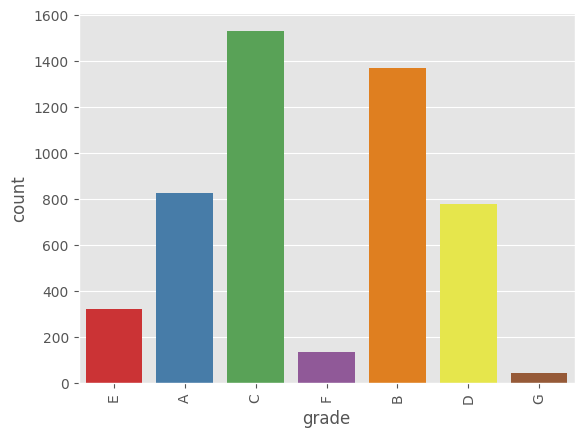

In [177]:
datos.emp_length.value_counts()
sns.countplot(x='grade', data = datos, palette='Set1')
plt.xticks(rotation=90)

Uso de pandas.get_dummies() para transformar la variable en una versión one-hot-encoded

In [178]:
# Convierta aa one-hot-encoding para incorporar la calificación ("grade"), que es categórica
calif_categ = pd.get_dummies(datos['grade'], prefix = "grade", drop_first=True)
calif_categ.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
27,False,False,False,True,False,False
767,False,False,False,False,False,False
3663,False,True,False,False,False,False
2567,False,False,False,False,True,False
3664,False,True,False,False,False,False


In [179]:
# Convertir los valores de True/False a 1/0 
calif_categ = calif_categ.applymap(lambda x: 1 if x else 0)

calif_categ.head()

,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
27,0,0,0,1,0,0
767,0,0,0,0,0,0
3663,0,1,0,0,0,0
2567,0,0,0,0,1,0
3664,0,1,0,0,0,0


2.6.1. Se añade esta característica al modelo totalmente numérico de antes

In [180]:
X_calif = pd.concat([X_completo, calif_categ],axis=1)
X_calif.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,install_income,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
27,4.875061,3.539703,0.0,0.0,29.84,10,4.0,4.290035,6.0,0.0,60,0.0,0.0,0.093859,0,0,0,1,0,0
767,5.113943,3.320562,0.0,0.0,16.02,2,0.0,4.176091,4.0,0.0,36,0.0,0.0,0.042976,0,0,0,0,0,0
3663,4.778151,3.570193,0.0,0.0,19.26,6,0.0,4.017033,3.0,0.0,60,0.0,0.0,0.050572,0,1,0,0,0,0
2567,4.748188,4.363725,0.0,0.0,31.00,10,4.0,4.176091,1.0,0.0,36,1.0,0.0,0.134156,0,0,0,0,1,0
3664,4.633468,3.019532,0.0,0.0,7.70,4,1.0,3.995635,4.0,0.0,36,0.0,0.0,0.093078,0,1,0,0,0,0


In [181]:
auc_lista = cross_validation_AUC(X_calif, y_completo)
modelos_desempeno["TODAS_NUMERICAS_Y_CALIFICACION"] = auc_lista

Text(0, 0.5, 'AUC')

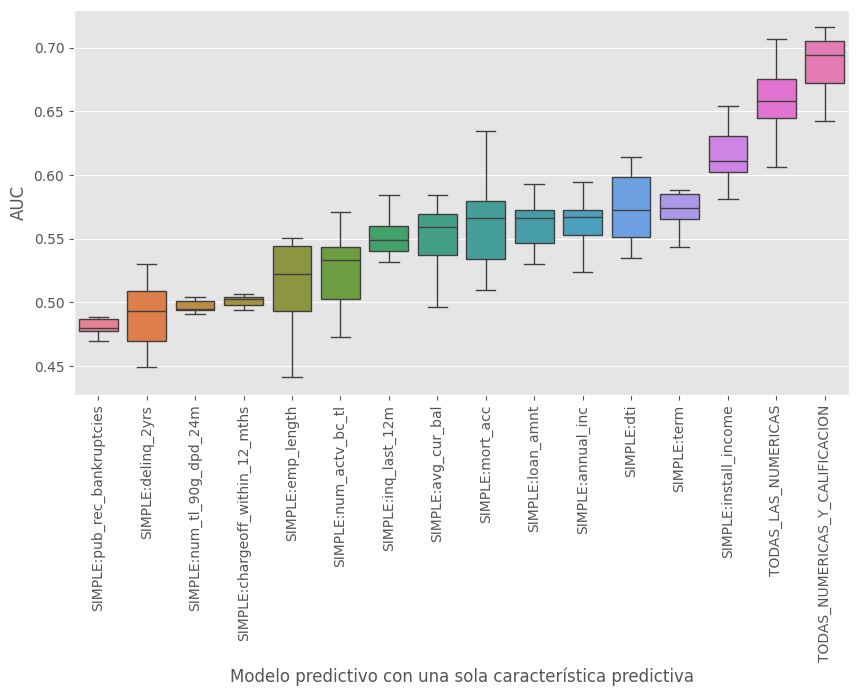

In [182]:
plt.figure(figsize= (10,5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola característica predictiva")
plt.ylabel("AUC")

Se observa que la diferencia parece significativa pues el boxplot del modelo actualizado casi no se solapa con el del modelo anterior

2.6.2. Se analiza si la variable categórica job aporta algún valor predictivo cuando se añade al mejor modelo actual

Text(0.5, 1.0, 'Tasa de impago por tipo de empleo')

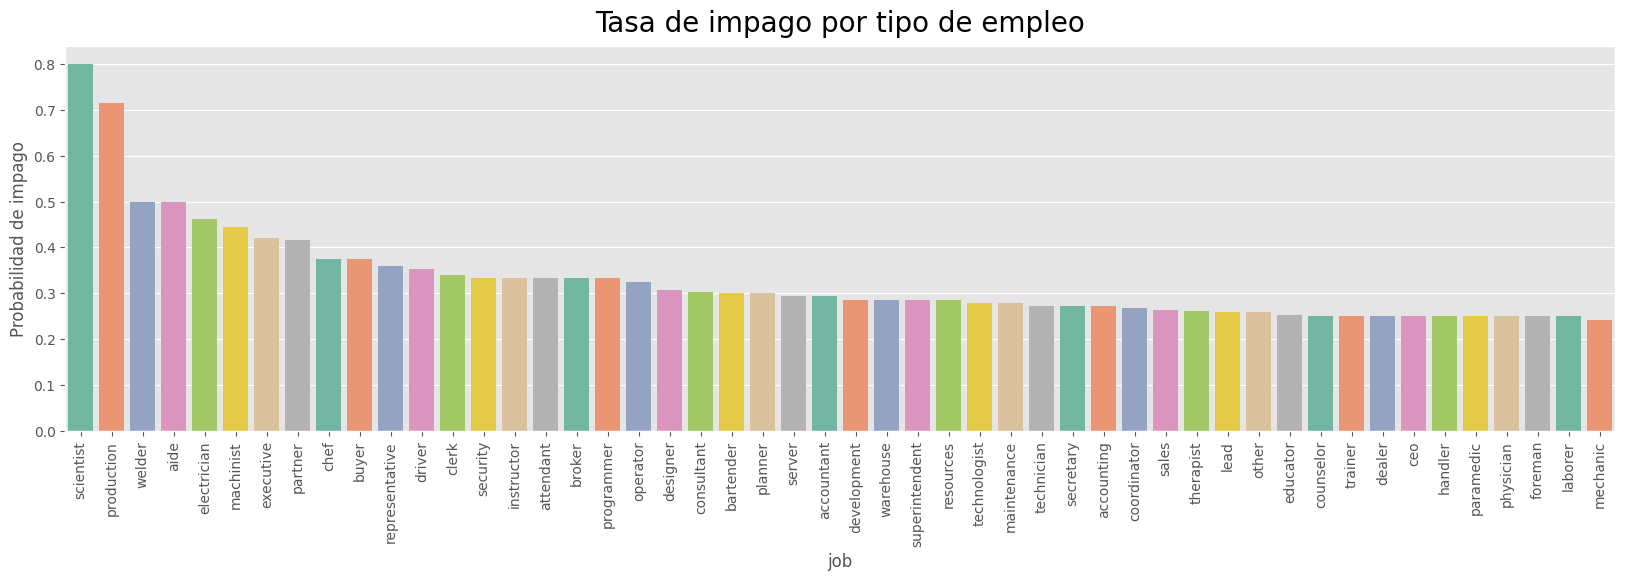

In [183]:
plt.figure(figsize= (20,5))
df_trabajo_impago = datos[["loan_default", "job"]].groupby("job").mean()
df_trabajo_impago = df_trabajo_impago.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_trabajo_impago.index[:50],
y=df_trabajo_impago["loan_default"][:50].values,
orient="v",
palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("Probabilidad de impago")
plt.title("Tasa de impago por tipo de empleo", fontsize=20, verticalalignment='bottom')

In [184]:
# Convertimos a one-hot-encoding para incorporar la variable "job", que es categórica
trabajo_categ = pd.get_dummies(datos['job'], prefix = "job", drop_first=True)
trabajo_categ = trabajo_categ.applymap(lambda x: 1 if x else 0)

In [185]:
X_calif_trabajo = pd.concat([X_calif,trabajo_categ],axis=1)
X_calif_trabajo.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,...,job_technician,job_technologist,job_teller,job_therapist,job_trainer,job_underwriter,job_vp,job_warehouse,job_welder,job_worker
27,4.875061,3.539703,0.0,0.0,29.84,10,4.0,4.290035,6.0,0.0,...,0,0,0,0,0,0,0,0,0,0
767,5.113943,3.320562,0.0,0.0,16.02,2,0.0,4.176091,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3663,4.778151,3.570193,0.0,0.0,19.26,6,0.0,4.017033,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2567,4.748188,4.363725,0.0,0.0,31.00,10,4.0,4.176091,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3664,4.633468,3.019532,0.0,0.0,7.70,4,1.0,3.995635,4.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [186]:
X_calif_trabajo.keys()


Index(['annual_inc', 'avg_cur_bal', 'chargeoff_within_12_mths', 'delinq_2yrs',
       'dti', 'emp_length', 'inq_last_12m', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies',
       ...
       'job_technician', 'job_technologist', 'job_teller', 'job_therapist',
       'job_trainer', 'job_underwriter', 'job_vp', 'job_warehouse',
       'job_welder', 'job_worker'],
      dtype='object', length=132)

In [187]:
auc_lista = cross_validation_AUC(X_calif_trabajo, y_completo)
modelos_desempeno["TODAS_LAS_NUMERICAS_CON_CALIFICACION_TRABAJO"] = auc_lista

Text(0, 0.5, 'AUC')

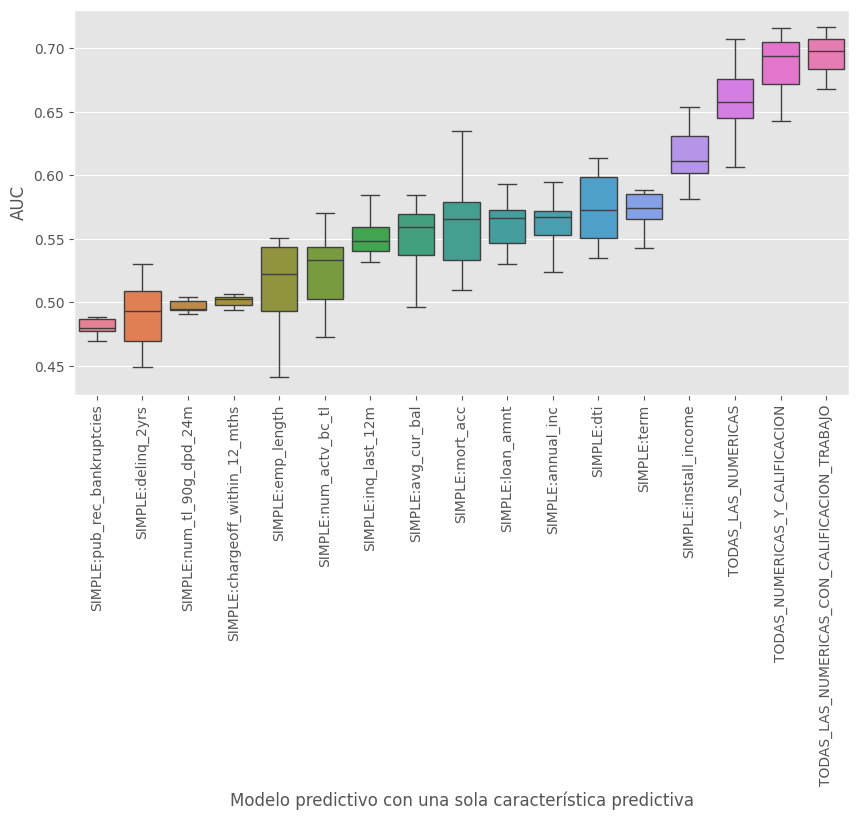

In [188]:
plt.figure(figsize= (10,5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola característica predictiva")
plt.ylabel("AUC")

2.6.3. Se analiza si la variable categórica "purpose" aporta algún valor predictivo cuando se añade al mejor modelo actual "TODAS_NUMERICAS_Y_CALIFICACION"

Text(0.5, 1.0, 'Tasa de impago por purpose')

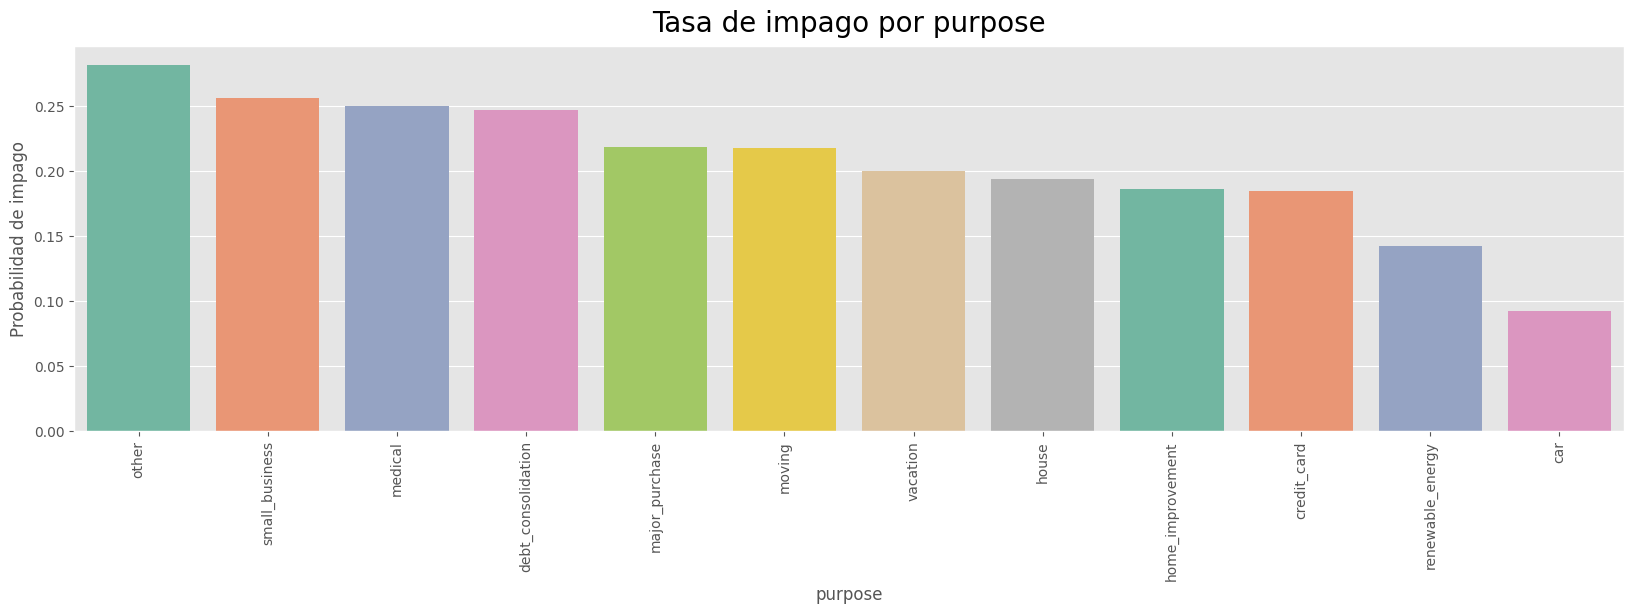

In [189]:
plt.figure(figsize= (20,5))
df_trabajo_impago = datos[["loan_default", "purpose"]].groupby("purpose").mean()
df_trabajo_impago = df_trabajo_impago.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_trabajo_impago.index[:50],
y=df_trabajo_impago["loan_default"][:50].values,
orient="v",
palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("Probabilidad de impago")
plt.title("Tasa de impago por purpose", fontsize=20, verticalalignment='bottom')

In [190]:
# Convertimos a one-hot-encoding para incorporar la variable "purpose", que es categórica
purpose_categ = pd.get_dummies(datos['purpose'], prefix = "purpose", drop_first=True)
purpose_categ = purpose_categ.applymap(lambda x: 1 if x else 0)

Se concatena con X_calif que contiene la calificación crediticia "grade"

In [191]:
X_calif_purpose = pd.concat([X_calif, purpose_categ],axis=1)
X_calif_purpose.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
27,4.875061,3.539703,0.0,0.0,29.84,10,4.0,4.290035,6.0,0.0,...,1,0,0,0,0,0,0,0,0,0
767,5.113943,3.320562,0.0,0.0,16.02,2,0.0,4.176091,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3663,4.778151,3.570193,0.0,0.0,19.26,6,0.0,4.017033,3.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2567,4.748188,4.363725,0.0,0.0,31.00,10,4.0,4.176091,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3664,4.633468,3.019532,0.0,0.0,7.70,4,1.0,3.995635,4.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [192]:
auc_lista = cross_validation_AUC(X_calif_purpose, y_completo)
modelos_desempeno["TODAS_LAS_NUMERICAS_CON_CALIFICACION_PURPOSE"] = auc_lista

Text(0, 0.5, 'AUC')

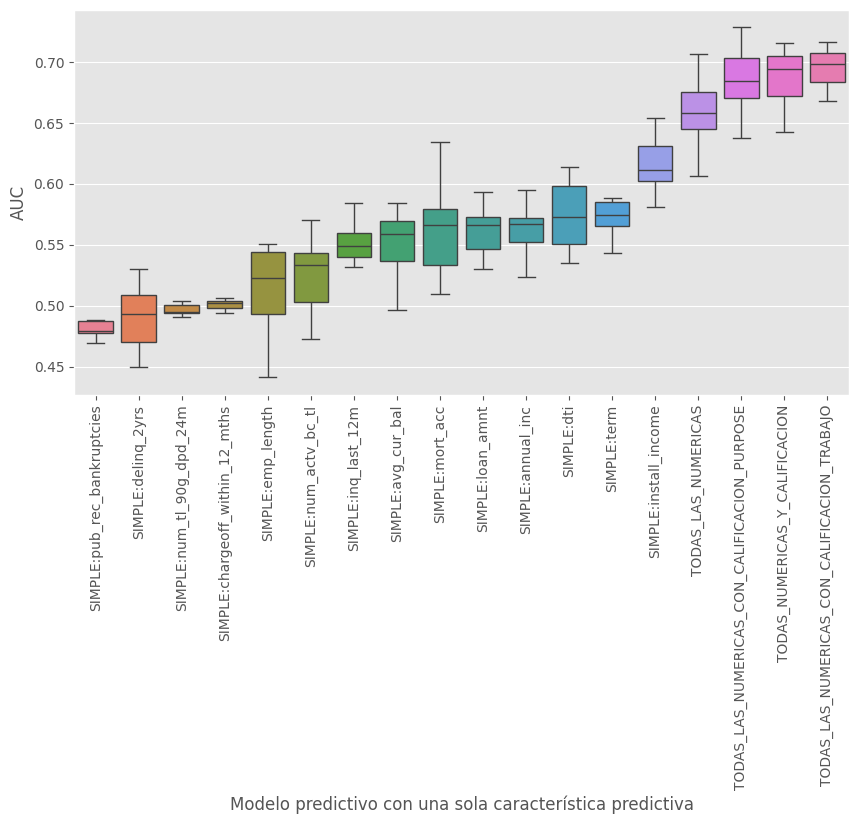

In [193]:
plt.figure(figsize= (10,5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola característica predictiva")
plt.ylabel("AUC")

2.6.4. Se analiza si la variable categórica "home_ownership" aporta algún valor predictivo cuando se añade al mejor modelo actual "TODAS_NUMERICAS_Y_CALIFICACION"

Text(0.5, 1.0, 'Tasa de impago por home_ownership')

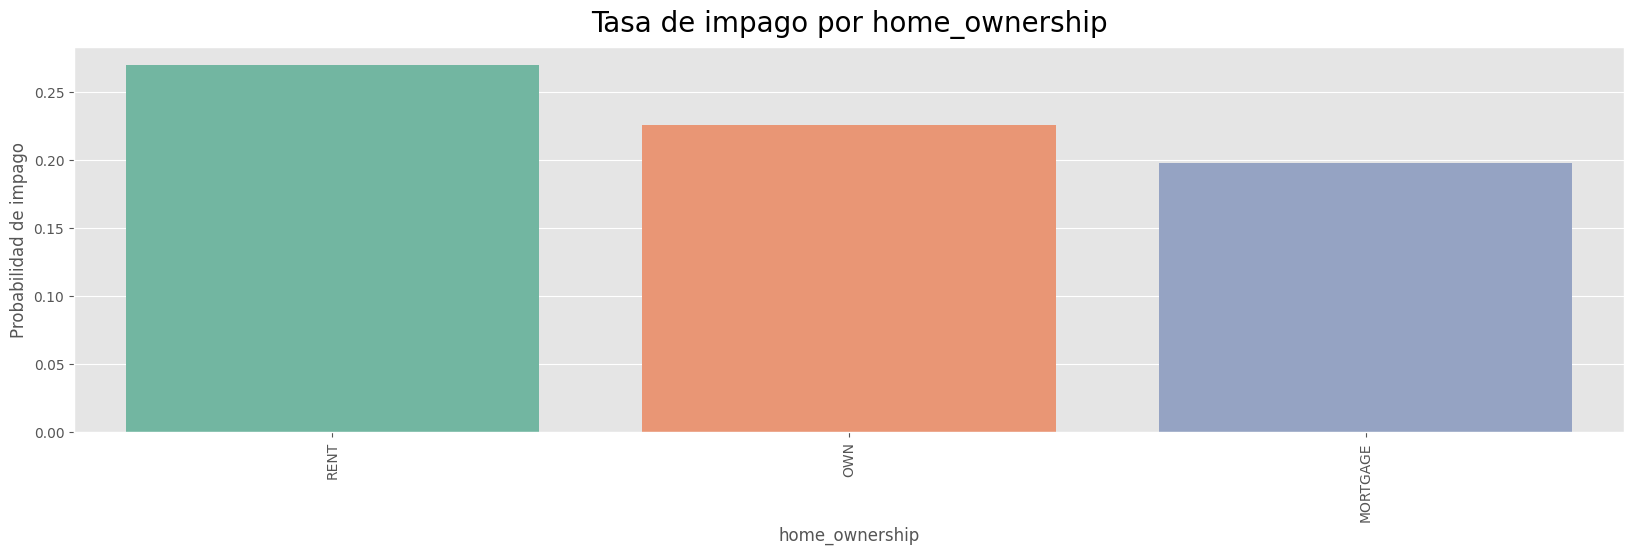

In [194]:
plt.figure(figsize= (20,5))
df_trabajo_impago = datos[["loan_default", "home_ownership"]].groupby("home_ownership").mean()
df_trabajo_impago = df_trabajo_impago.sort_values(by="loan_default",axis=0, ascending=False)
sns.barplot(x=df_trabajo_impago.index[:50],
y=df_trabajo_impago["loan_default"][:50].values,
orient="v",
palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("Probabilidad de impago")
plt.title("Tasa de impago por home_ownership", fontsize=20, verticalalignment='bottom')

In [195]:
# Convertimos a one-hot-encoding para incorporar la variable "home_ownership", que es categórica
home_ownership_categ = pd.get_dummies(datos['home_ownership'], prefix = "home_ownership", drop_first=True)
home_ownership_categ = home_ownership_categ.applymap(lambda x: 1 if x else 0)

Se concatena con X_calif que contiene la calificación crediticia "grade"

In [196]:
X_calif_home = pd.concat([X_calif, home_ownership_categ],axis=1)
X_calif_home.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,...,num_tl_90g_dpd_24m,install_income,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OWN,home_ownership_RENT
27,4.875061,3.539703,0.0,0.0,29.84,10,4.0,4.290035,6.0,0.0,...,0.0,0.093859,0,0,0,1,0,0,0,1
767,5.113943,3.320562,0.0,0.0,16.02,2,0.0,4.176091,4.0,0.0,...,0.0,0.042976,0,0,0,0,0,0,0,0
3663,4.778151,3.570193,0.0,0.0,19.26,6,0.0,4.017033,3.0,0.0,...,0.0,0.050572,0,1,0,0,0,0,0,1
2567,4.748188,4.363725,0.0,0.0,31.00,10,4.0,4.176091,1.0,0.0,...,0.0,0.134156,0,0,0,0,1,0,0,0
3664,4.633468,3.019532,0.0,0.0,7.70,4,1.0,3.995635,4.0,0.0,...,0.0,0.093078,0,1,0,0,0,0,0,1


In [197]:
auc_lista = cross_validation_AUC(X_calif_home, y_completo)
modelos_desempeno["TODAS_LAS_NUMERICAS_CON_CALIFICACION_HOME"] = auc_lista

Text(0, 0.5, 'AUC')

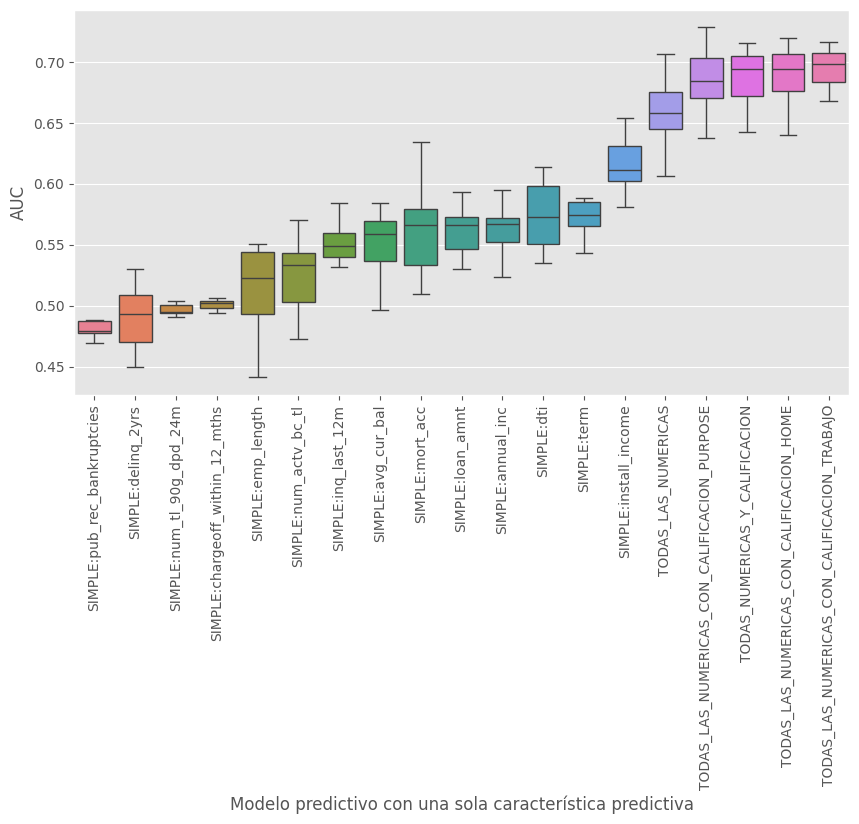

In [198]:
plt.figure(figsize= (10,5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola característica predictiva")
plt.ylabel("AUC")

2.6.5. Se concatena con X_calif_purpose que contiene la calificación crediticia "grade" y "purpose"

In [199]:
X_calif_purpose_home = pd.concat([X_calif_purpose, home_ownership_categ],axis=1)
X_calif_purpose_home.head()

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,inq_last_12m,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,home_ownership_OWN,home_ownership_RENT
27,4.875061,3.539703,0.0,0.0,29.84,10,4.0,4.290035,6.0,0.0,...,0,0,0,0,0,0,0,0,0,1
767,5.113943,3.320562,0.0,0.0,16.02,2,0.0,4.176091,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3663,4.778151,3.570193,0.0,0.0,19.26,6,0.0,4.017033,3.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2567,4.748188,4.363725,0.0,0.0,31.00,10,4.0,4.176091,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3664,4.633468,3.019532,0.0,0.0,7.70,4,1.0,3.995635,4.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [200]:
auc_lista = cross_validation_AUC(X_calif_purpose_home, y_completo)
modelos_desempeno["TODAS_LAS_NUMERICAS_CON_CALIFICACION_PURPOSE_HOME"] = auc_lista

Text(0, 0.5, 'AUC')

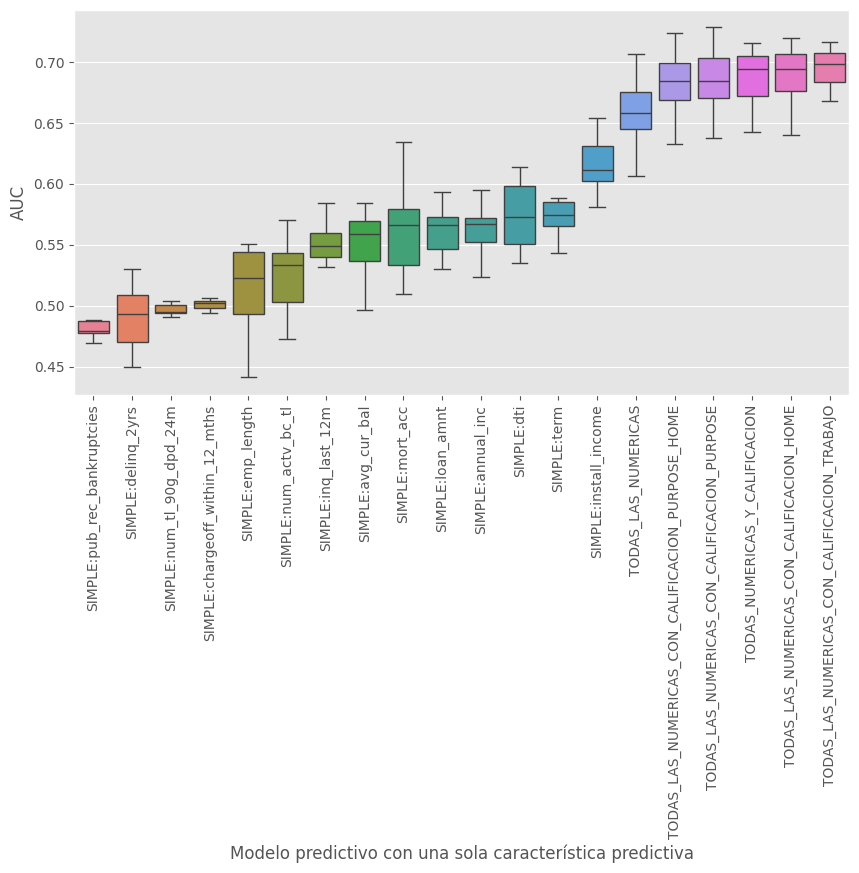

In [201]:
plt.figure(figsize= (10,5))
dibujar_boxplot_ordenado(modelos_desempeno)
plt.xlabel("Modelo predictivo con una sola característica predictiva")
plt.ylabel("AUC")

#### 2.7. Observaciones
Podemos ver que los boxplots se superponen significativamente, por lo que no hay un beneficio discernible. Se desprende que se puede usar la mera lógica. Es decir, se sabe que existe una notable mejora al añadir una variable categórica, pero no al añadir 2 o 3. Esto quiere decir que se puede elegir la que le parece mejor a cada quien. Creo que elejir la variable "grade" es la mejor opción. Un AUC entre 0.65 y 0.75 no es el ideal, pero es mejor que si no tendrías dicho modelo.

#### 2.8. Conclusiones
En este caso, primero exploramos el conjunto de datos de préstamos y encontramos las asociaciones de una sola variable entre las características disponibles y la tasa de impago. También descubrimos qué características requerían transformaciones (por ejemplo, la transformación logarítmica). Una vez que empezamos a construir los modelos, comenzamos con enfoques de regresiones logísticas muy
simples; estos modelos de referencia fueron útiles para evaluar rápidamente el poder de predicción de cada variable individual. A continuación, empleamos validación cruzada para construir modelos más complejos, explotando a menudo las interacciones entre las diferentes características. Dado que el conjunto de datos de préstamos contiene un gran número de covariables, el uso de la validación cruzada fue crucial para evitar el exceso de ajuste, elegir el número correcto de características y, en última instancia, elegir un modelo
apropiado que equilibrara la complejidad con la precisión.

#### 2.9. Puntos clave
La validación cruzada es una técnica robusta y flexible para evaluar el rendimiento predictivo de los modelos estadísticos. Es especialmente útil en entornos de *big data* en los que el número de características es grande en comparación con el número de observaciones. Cuando se utiliza adecuadamente, la validación cruzada es un método poderoso para elegir un modelo con la complejidad correcta y el mejor rendimiento predictivo.